# <center>Лабораторная работа №8
## <center>Реализация алгоритмов онлайн-обучения

Вам предлагается реализовать два алгоритма – регрессор и классификатор, обучаемые стохастическим градиентным спуском (Stochastic Gradient Descent, SGD).

## План домашнего задания
    1. Линейная регрессия и SGD
    2. Логистическая регрессия и SGD
    3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

В [лекции](https://nbviewer.jupyter.org/github/soolstafir/Machine-learning-course/blob/master/Lections/ml_lection08_sgd_hashing_vowpal_wabbit/ml_lection08_sgd_hashing_vowpal_wabbit.ipynb) было описано, как таким образом обучать регрессор, т.е. минимизировать квадратичную функцию потерь. Реализуем этот алгоритм.

##  1. Линейная регрессия и SGD

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

Реализуйте класс `SGDRegressor`. Спецификация:
- класс наследуется от `sklearn.base.BaseEstimator`
- конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию $10^{-3}$) и `n_iter` – число проходов по выборке (по умолчанию 10)
- также в конструкторе должны создаваться списки `mse_` и `weights_` для отслеживания значений среднеквадратичной ошибки и вектора весов по итерациям градиентного спуска
- Класс имеет методы `fit` и `predict`
- Метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` **нулями** и в цикле с числом итераций `n_iter` обновляет веса (см. [статью](https://habrahabr.ru/company/ods/blog/326418/)), а также записывает получившиеся на данной итерации значения среднеквадратичной ошибки (именно MSE, SE слишком большими будут) и вектор весов `w` в предназначенные для этого списки. 
- В конце метод `fit` создает переменную `w_`, в которой хранится тот вектор весов, при котором ошибка минимальна
- Метод `fit` должен возвращать текущий экземпляр класса `SGDRegressor`, т.е. `self`
- Метод `predict` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает вектор прогнозов модели, используя созданный методом `fit` вектор весов `w_`.

In [2]:
class SGDRegressor(BaseEstimator):
    
    def __init__(self, eta=1e-3, n_iter=10):
        self.eta = eta
        self.n_iter = n_iter
        self.mse_ = []
        self.weights_ = []
        
    def fit(self, X, y):
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        
        w = np.zeros(X.shape[1])
        
        for it in tqdm(range(self.n_iter)):
            for i in range(X.shape[0]):
                
                new_w = w.copy()
                new_w[0] += self.eta * (y[i] - w.dot(X[i, :]))
                for j in range(1, X.shape[1]):
                    new_w[j] += self.eta * (y[i] - w.dot(X[i, :])) * X[i, j]  
                w = new_w.copy()
                
                self.weights_.append(w)
                self.mse_.append(mean_squared_error(y, X.dot(w)))
                
        self.w_ = self.weights_[np.argmin(self.mse_)]
                
        return self
                  
    def predict(self, X):
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        
        return X.dot(self.w_)

Проверим работу алгоритма на данных по росту и весу. Будем прогнозировать рост (в дюймах) по весу (в фунтах).

In [3]:
data_demo = pd.read_csv('weights_heights.csv')

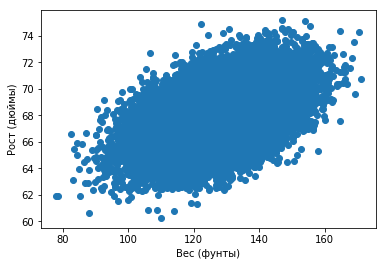

In [4]:
plt.scatter(data_demo['Weight'], data_demo['Height']);
plt.xlabel('Вес (фунты)')
plt.ylabel('Рост (дюймы)');

In [5]:
X, y = data_demo['Weight'].values, data_demo['Height'].values

Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                     test_size=0.3,
                                                     random_state=17)

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape([X_train.shape[0], 1]))
X_valid_scaled = scaler.transform(X_valid.reshape([X_valid.shape[0], 1]))

Обучите созданный вами `SGDRegressor` на выборке `(X_train_scaled, y_train)`. Параметры оставьте по умолчанию.

In [9]:
sgd_reg = SGDRegressor()
sgd_reg.fit(X_train_scaled, y_train)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:59<00:00,  5.93s/it]


SGDRegressor(eta=0.001, n_iter=10)

Изобразите на графике процесс обучения – как среднеквадратичная ошибка зависит от номера итерации стохастического градиентного спуска.

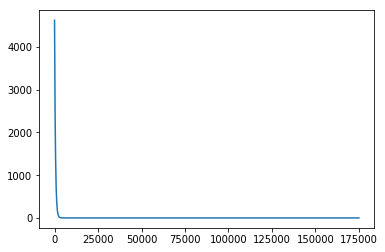

In [10]:
plt.plot(range(len(sgd_reg.mse_)), sgd_reg.mse_);

Выведите наименьшее значение среднеквадратичной ошибки и лучший вектор весов модели.

In [11]:
np.min(sgd_reg.mse_), sgd_reg.w_

(2.7151352406643627, array([67.9898497 ,  0.94447605]))

Постройте график того, как менялись значения весов модели ($w_0$ и $w_1$) по мере обучения.

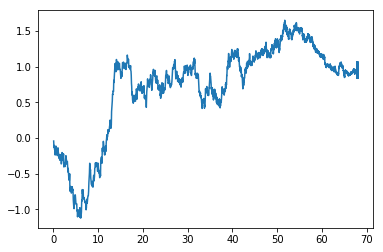

In [12]:
plt.plot([w[0] for w in sgd_reg.weights_], 
         [w[1] for w in sgd_reg.weights_]);

Сделайте прогноз для отложенной выборки `(X_valid_scaled, y_valid)` и посмотрите на MSE.

In [13]:
mean_squared_error(y_valid, sgd_reg.predict(X_valid_scaled))

2.6708681207033784

Теперь следайте то же самое, но с `LinearRegression` из `sklearn.linear_model`. Посчитайте MSE для отложенной выборки.

In [14]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression().fit(X_train_scaled, y_train)
lm.coef_, lm.intercept_

(array([0.94537278]), 67.98930834742858)

In [15]:
mean_squared_error(y_valid, lm.predict(X_valid_scaled))

2.670830767667635

<font color='red'>Вопрос 1.</font> В каком знаке после разделителя отличаются MSE линейной регрессии и `SGDRegressor` для отложенной выборки?
 - 2
 - 3
 - 4
 - 5 Ответ

## 2. Логистическая регрессия и SGD
Теперь давайте разберемся, как при таком же стохастическом подходе обучать логистическую регрессию.

Задача классификации, $X$ – обучающая выборка размеров $\ell \times (d+1)$ (первый столбец – вектор из единиц), $y$ – вектор ответов, $y_i \in \{-1, 1\}$.
В [4 статье](https://habrahabr.ru/company/ods/blog/323890/) серии мы подробно разбирали, как логистическая регрессия с $L_2$-регуляризацией сводится к задаче минимизации:
$$ C\sum_{i=1}^\ell \log{(1 + e^{-y_iw^Tx_i})} + \frac{1}{2}\sum_{j=1}^d w_j^2 \rightarrow min_w$$

<font color='red'>Вопрос 2.</font> По какой формуле будут пересчитываться веса логистической регрессии при обучении стохастическим градиентным спуском?
 - $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(y_iw^Tx_i) +  \delta_{j\neq0} w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) +  \delta_{j\neq0}w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) -  \delta_{j\neq0}w_j )$
 - $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(y_iw^Tx_i) -  \delta_{j\neq0}w_j)$
 
Здесь 
- $i \in {0,\ldots, \ell-1}, j \in {0,\ldots, d}$
- C – коэффициент регуляризации
- $x_{ij} $ – элемент матрицы X в строке $i$ и столбце $j$ (нумерация с 0), 
- $x_i$ – $i$-ая строка матрицы $X$ (нумерация с 0), 
- $w_j^{(t)}$ – значение $j$-ого элемента вектора весов $w$ на шаге $t$ стохастического градиентного спуска
- $\eta$ – небольшая константа, шаг градиентного спуска
- $\delta_{j\neq0}$ – символ Кронекера, то есть 1, когда $j\neq0$ и $0$ – в противном случае

Реализуйте класс `SGDClassifier`. Спецификация:
- класс наследуется от `sklearn.base.BaseEstimator`
- конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию $10^{-3}$), `n_iter` – число проходов по выборке (по умолчанию 10) и C – коэффициент регуляризации
- также в конструкторе должны создаваться списки `loss_` и `weights_` для отслеживания значений логистических потерь и вектора весов по итерациям градиентного спуска
- Класс имеет методы `fit`, `predict` и `predict_proba`
- Метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`, рассматриваем только случай бинарной классификации, и значения в векторе `y` могут быть -1 и 1), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` **нулями** и в цикле с числом итераций `n_iter` обновляет веса по выведенной вами формуле, а также записывает получившиеся на данной итерации значения log_loss и вектор весов `w` в предназначенные для этого списки. 
- В конце метод `fit` создает переменную `w_`, в которой хранится тот вектор весов, при котором ошибка минимальна
- Метод `fit` должен возвращать текущий экземпляр класса `SGDClassifier`, т.е. `self`
- Метод `predict_proba` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает матрицу прогнозов модели (такую же, какую возвращают методы `predict_proba` моделей `sklearn`), используя созданный методом `fit` вектор весов `w_`
- Метод `predict` вызывает метод  `predict_proba` и возвращает вектор ответов: -1, если предсказанная вероятность класса 1 меньше 0.5 и 1 – в противном случае
- И еще **важный момент**: во избежание вычислительных проблем из-за слишком больших или малых значений под экспонентной (overflow & underflow) используйте написанную функцию `sigma`

In [22]:
def sigma(z):
    z = z.flatten()
    z[z > 100] = 100
    z[z < -100] = -100
    return 1. / (1 + np.exp(-z))

In [23]:
class SGDClassifier(BaseEstimator):
    def __init__(self, C=1, eta=1e-3, n_iter=10):
        self.eta = eta
        self.C = C
        self.n_iter = n_iter
        self.loss_ = []
        self.weights_ = []
        
    def fit(self, X, y):
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        best_loss = np.inf
        w = np.zeros(X.shape[1])
        
        for it in tqdm(range(self.n_iter)):
            for i in range(X.shape[0]):
                
                new_w = w.copy()
                
                new_w[0] += self.eta * self.C * y[i] * sigma(- y[i] * w.dot(X[i, :]))
                for j in range(1, X.shape[1]):
                    new_w[j] += self.eta *( self.C * y[i] * X[i, j] * 
                                       sigma(-y[i] * w.dot(X[i, :]))
                                    -  w[j])
                    
                w = new_w.copy()
                
                self.loss_.append(log_loss(y, sigma(X.dot(w))))
                self.weights_.append(w)
    
        self.w_ = self.weights_[np.argmin(self.loss_)]
        return self
                  
    def predict_proba(self, X):
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        p_vec = sigma(X.dot(self.w_)).reshape([X.shape[0], 1])
        return np.hstack([1 - p_vec, p_vec])
    
    def predict(self, X):
        pred_probs = self.predict_proba(X)[:, 1]
        signs = np.sign(pred_probs - 0.5) 
        signs[np.where(signs == 0)] = 1
        return signs
                  

Проверим `SGDClassifier` на данных UCI по раку молочной железы.

In [24]:
from sklearn.datasets import load_breast_cancer

In [25]:
cancer = load_breast_cancer()
# поменяем метки в y с 0 на -1
X, y = cancer.data, [-1 if i == 0 else 1 for i in cancer.target]

Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.

In [26]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                     test_size=0.3,
                                                     random_state=17)

In [27]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

Обучите на масштибированной выборке `SGDClassifier` с параметрами `C`=1, `eta`=$10^{-3}$ и `n_iter`=3.

In [28]:
sgd_clf = SGDClassifier(C=1, n_iter=3, eta=1e-3)
sgd_clf.fit(X_train_scaled, y_train)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.31it/s]


SGDClassifier(C=1, eta=0.001, n_iter=3)

Постройте график изменения log_loss.

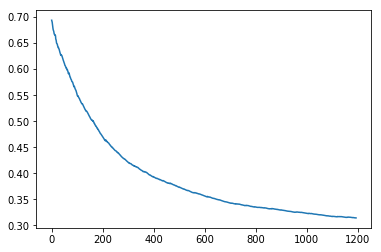

In [29]:
plt.plot(range(len(sgd_clf.loss_)), sgd_clf.loss_);

Теперь обучите `SGDClassifier` с параметром `C`=1000, число проходов по выборке увеличьте до 10.

In [30]:
sgd_clf = SGDClassifier(C=1000, n_iter=10)
sgd_clf.fit(X_train_scaled, y_train)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.16it/s]


SGDClassifier(C=1000, eta=0.001, n_iter=10)

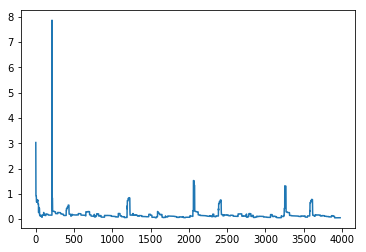

In [31]:
plt.plot(range(len(sgd_clf.loss_)), sgd_clf.loss_);

Посмотрите на веса модели, при которых ошибка на обучении была минимальна.

<font color='red'>Вопрос 3.</font> Какой признак сильнее остальных влияет на вероятность того, что опухоль доброкачественна, согласно обученной модели `SGDClassifier`? (будьте внимательны – проверьте длину вектора весов, полученного после обучения, сравните с числом признаков в исходной задаче)
 - worst compactness
 - worst smoothness
 - worst concavity - Ответ
 - concave points error
 - concavity error
 - compactness error
 - worst fractal dimension

In [32]:
best_w = sgd_clf.weights_[np.argmin(sgd_clf.loss_)]
pd.DataFrame({'coef': best_w,
             'feat': ['intercept'] + list(cancer.feature_names)}).sort_values(by='coef')

,coef,feat
27,-5.107343,worst concavity
11,-4.531819,radius error
22,-4.051564,worst texture
7,-3.566910,mean concavity
8,-3.543276,mean concave points
2,-3.413874,mean texture
14,-3.154584,area error
21,-2.924186,worst radius
13,-2.575289,perimeter error
24,-2.511385,worst area


Посчитайте log_loss и ROC AUC на отложенной выборке, проделайте все то же с `sklearn.linear_model.LogisticRegression` (параметры по умолчанию, только random_state=17) и сравните результаты.

In [33]:
log_loss(y_valid, sgd_clf.predict_proba(X_valid_scaled)[:, 1])

0.4344110793957859

In [34]:
roc_auc_score(y_valid, sgd_clf.predict_proba(X_valid_scaled)[:,1])

0.9763040238450075

In [35]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(random_state=17).fit(X_train_scaled, y_train)
cancer.feature_names[np.argmin(logit.coef_.flatten())]

C:\Users\Phobia\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


'radius error'

In [36]:
log_loss(y_valid, logit.predict_proba(X_valid_scaled)[:,1])

0.10569213477936719

In [37]:
roc_auc_score(y_valid, logit.predict_proba(X_valid_scaled)[:,1])

0.9892697466467958

## 3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

Теперь посмотрим на логистическую регрессию и ее же версию, но обучаемую стохастическим градиентным спуском, в задаче классификации отзывов IMDB. С этой задачей мы знакомы по 4 и 8 темам курса. Данные можно скачать [отсюда](https://drive.google.com/open?id=1xq4l5c0JrcxJdyBwJWvy0u9Ad_pvkJ1l).

Импортируем файлы, и обучим на имеющихся данных `CountVectorizer`

In [38]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier

In [42]:
# поменяйте путь к файлу
reviews_train = load_files("imdb_reviews/train")
text_train, y_train = reviews_train.data, reviews_train.target

In [43]:
reviews_test = load_files("imdb_reviews/test")
text_test, y_test = reviews_test.data, reviews_test.target

Обучим на имеющихся данных `CountVectorizer`, считая биграммы, то есть перейдем к разреженному представлению данных, где каждому уникальному слову и паре подряд идущих слов в обучающей выборке соответсвует признак. Всего таких признаков получается более 1.5 млн.

In [44]:
%%time
cv = CountVectorizer(ngram_range=(1, 2))
X_train = cv.fit_transform(text_train)
X_test = cv.transform(text_test)

Wall time: 55.5 s


In [45]:
X_train.shape, X_test.shape

((25000, 1513832), (25000, 1513832))

Обучите на выборке `(X_train, y_train)` логистическую регрессию с параметрами по умолчанию (только укажите `random_state`=17) и посчитайте ROC AUC на тестовой выборке. Замерьте время обучения модели. Данные можно не масштабировать, так как признаки – по сути, счетчики, и они уже все измеряются примерно в одном диапазоне.

In [46]:
%%time 
logit = LogisticRegression(random_state=17)
logit.fit(X_train, y_train);

C:\Users\Phobia\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Wall time: 1min 34s


In [48]:
roc_auc_score(y_test, logit.predict_proba(X_test)[:, 1])

0.9582500416

Теперь перейдем к онлайн-алгоритму. Мы написали свой `SGDClassifier` и принцип его работы поняли, надо еще немного постараться, чтобы сделать его эффективным, например, сделать поддержку разреженных данных. Но мы теперь перейдем к `sklearn`-реализации SGD-алгоритма. Прочитайте документацию [SGDClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html), сделайте выводы, чем `SGDClassifier` из `Sklearn` более продвинут, чем наша реализация SGD-классификатора. 

<font color='red'>Вопрос 4.</font> Чем `sklearn`-реализация стохастического классификатора более продвинута, чем `SGDClassifier`, который мы реализовали? Отметьте все подходящие варианты.
 - <b>Изменяемый шаг градиентного спуска</b>
 - <b>Реализован линейный SVM</b>
 - Реализована ранняя остановка во избежание переобучения
 - <b>Есть распараллеливание по процессорам</b>
 - <b>Можно обучать LASSO</b>
 - Поддерживается онлайн-обучение деревьев решений
 - <b>Поддерживается mini-batch подход (обновление весов по нескольким объектом сразу, а не по одному)</b>


Проведите 100 итераций SGD-логрегрессии (опять `random_state`=17) на той же выборке. Опять замерьте время обучения модели и обратите внимание, насколько оно меньше, чем время обучения логистической регрессии.

In [49]:
sgd_logit = SGDClassifier(loss='log', random_state=17,
                         n_iter=100)

In [50]:
%%time
sgd_logit.fit(X_train, y_train)

C:\Users\Phobia\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Wall time: 14.8 s


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=100, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=17, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [51]:
roc_auc_score(y_test, sgd_logit.predict_proba(X_test)[:, 1])

0.9574023488000001

<font color='red'>Вопрос 5.</font> В каком знаке после разделителя отличаются ROC AUC на тестовой выборке логистической регрессии и SGD-классификатора `Sklearn` с логистической функцией потерь?
 - 2
 - <b>3</b>
 - 4
 - 5